### Group ID: HaKaPr 
### Assignment 03
● Submitted by:
1. Kanishk Chugh (2004215)<br>
2. Prem Swarup (2003318)<br>
3. Harshvardhan Gupta (2003310) <br>
● Team Code: HaKaPr<br>
● Course Instructor: Dr. Satyanath Bhat<br>
● Course: Machine Learning (CS-331)<br>



## Question 1:

##Create a Neural Network class. This class takes in list of Layer objects. It also takes a loss object. You can also allow it to take a seed as input. The seed is used for reproduciblity across runs. Each layer is characterized by its activation function and count of output neuron. Examples of activation include linear (W x + b), sigmoid, tanh etc.


## Class Neural Network


In [9]:
class Neural_Network :
  # Initialize the neural network with a list of layers and a loss function
  def __init__(self, layer_list, loss_fun) :
    # Store the list of layers in the network
    self.layer_list = layer_list
    # Store the loss function used to calculate the loss
    self.loss_fun = loss_fun
    # Initialize the output of the network as None
    self.out = None 

  # Forward Pass
  def forward(self, x, y):
    # Store the input to the network as the output
    self.out = x
    # Loop through each layer in the network
    for layer_i in self.layer_list:
      # Pass the output from the previous layer as the input to the current layer
      self.out = layer_i.forward(self.out)
    # Calculate the loss using the loss function and the final output of the network
    self.loss = self.loss_fun.forward(self.out, y)
    # Return the calculated loss
    return self.loss

  # Backward Pass
  def backward(self):
    # Calculate the gradient with respect to the loss using the loss function
    self.grad = self.loss_fun.backward()
    # Loop through the layers in the network in reverse order
    for i in reversed(range(len(self.layer_list))):
      # Pass the gradient from the previous layer as the input to the current layer
      self.grad = self.layer_list[i].backward(self.grad)

### Dense Layer

In [10]:
import numpy as np

class Dense():
    def __init__(self, input_shape, output_size, learning_rate, activation=None, seed_W=None, seed_bias=None):
        self.weights = np.random.randn(output_size, input_shape[0])
        self.bias = np.random.randn(output_size, input_shape[1])
        if(seed_W is not None):
           self.weights = seed_W
        if(seed_bias is not None):
           self.bias = seed_bias
        # Activation function used in the dense layer
        self.activation = activation
        # Learning rate used in the dense layer
        self.learning_rate = learning_rate

    # Forward Pass for the Dense Layer
    def forward(self, input):
        self.input = input
        # Calculate the output of the dense layer by dot product of weights and input, then adding the biases
        self.output = np.dot(self.weights, self.input) + self.bias
        # If an activation function is provided, apply it to the output
        if(self.activation is not None):
          self.output = self.activation.forward(self.output)
        # Return the final output
        return self.output

    # Backward Pass for the Dense Layer
    def backward(self, output_gradient):
        # If an activation function is provided, apply the backward pass to it
        if(self.activation is not None):
          output_gradient = self.activation.backward(output_gradient)
        # Calculate the gradient with respect to the input
        self.d_out = np.dot(self.weights.T, output_gradient)
        # Calculate the gradient with respect to the weights
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= self.learning_rate * weights_gradient
        # Update the biases using the calculated gradient and the learning rate
        self.bias -= self.learning_rate * output_gradient
        # Return the gradient with respect to the input
        return self.d_out

## Linear Activation Function

In [11]:
class linear :
  # Initialize the alpha value for linear activation
  def __init__(self, alpha) :
    self.alpha = alpha
    pass

  # Calculate the forward pass of linear activation
  def forward(self, x) :
    return self.alpha*x

  # Calculate the backward pass of linear activation
  def backward(self, y) :
    return self.alpha*y

## Mean Square Loss Layer Class

In [12]:
import numpy as np
class MeanSquaredLossLayer:
  # Initialize y_pred and y_true to None
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        # Store the values of y_pred and y_true
        self.y_pred = y_pred
        self.y_true = y_true
        # Calculate the mean squared loss
        loss = np.mean((y_pred - y_true)**2)
        return loss

    def backward(self):
        # Calculate the gradient of the loss with respect to the prediction
        m = self.y_true.shape[1]
        d_L = (self.y_pred - self.y_true) / m
        return d_L

## Softmax Layer Class

In [13]:
class SoftmaxLayer():
    def __init__(self) :
      pass
    
    def forward(self, input):
        # Subtracting the maximum value from the input to avoid numeric instability
        mx = np.max(input, axis=0)
        tmp = input - mx 
        
        # Taking exponential of the input tensor
        tmp = np.exp(tmp)
        # Dividing the exponential tensor by the sum of exponential along the axis 0
        self.output = tmp / np.sum(tmp, axis=0)
        return self.output
    
    def backward(self, output_gradient):
        n = len(self.output)
        if(self.output.shape[1]>1) :
          # Reshaping the output tensor to be of shape (number of samples, number of features)
          self.output = self.output.reshape(self.output.shape[1], n, 1)
          d_out = np.ndarray((self.output.shape[0], n))
          for i in range(len(self.output)) :
             # Tile the output tensor to be of shape (number of features, number of features)
            tmp = np.tile(self.output[i], n)
            d_out[i] = np.dot(tmp*(np.identity(n) - tmp.T), output_gradient[:, i:i+1]).reshape(-1)
          return d_out.T
        
        # Tile the output tensor to be of shape (number of features, number of features)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - tmp.T), output_gradient)

## Cross-Entropy Loss Class

In [14]:

# The cross-entropy loss is defined as:

# L = - ∑ yi * log(pi)

# Where L is the loss, yi is the true label for the ith example and pi is the predicted probability of the true label for the ith example.


import numpy as np

class CrossEntropyLayer:
    def __init__(self):
        self.CE_out = None
        self.epsln = 10**(-10)
        self.Y_true = None
        self.s_out = None

    #Forward Pass
    def forward(self, s_out, Y_true):
        self.Y_true = Y_true
        self.s_out = s_out
        self.CE_out = 0
        
        for i in range(len(self.Y_true)) :
          # If true label is 0, add -log(1-pi) to the loss
          if(Y_true[i][0]==0) :
            self.CE_out += -1*np.log(1-self.s_out[i][0]+self.epsln)
          else :
            # If true label is 1, add -log(pi) to the loss
            self.CE_out += -1*np.log(self.s_out[i][0]+self.epsln)

        return self.CE_out

    # Backward Pass
    def backward(self):
        L_out  = np.zeros((self.s_out.shape[0],1))
        if(self.s_out.shape[1]>1) :
          for j in range(self.s_out.shape[1]) :
            for i in range(len(self.Y_true)) :
              if(self.Y_true[i][j]==0) :
                L_out[i][0] = 1/(1-self.s_out[i][j]+self.epsln)
              else :
                L_out[i][0] = -1/(self.s_out[i][j]+ self.epsln)
          return L_out/self.s_out.shape[1]
          
        for i in range(len(self.Y_true)) :
          if(self.Y_true[i][0]==0) :
            L_out[i][0] = 1/(1-self.s_out[i][0]+self.epsln)
          else :
            L_out[i][0] = -1/(self.s_out[i][0]+self.epsln)

        return L_out

## Sigmoid Class


In [15]:
import numpy as np

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, x):
        # code for sigmoid function
        self.x = x
        self.out = 1/(1+np.exp(-1*x))
        return self.out

    def backward(self, grad_output):
      
        # grad_output is the gradient of the loss with respect to the output activations
        return grad_output * self.out * (1 - self.out)

### Tanh Class


In [16]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        return np.tanh(x)
    
    def backward(self, output_gradient):
        x_gradient = output_gradient * (1 - np.tanh(self.x)**2)
        return x_gradient

### Q.2 1st 

### Standardisation of the Input data code

In [17]:
# Function to standardize the features of a dataset. 
# It subtracts the mean and divides by the standard deviation of each feature
def standardize(X):
    # Calculate the mean of each feature
    mean = np.mean(X, axis=0)

    # Calculate the standard deviation of each feature
    std = np.std(X, axis=0)

    # Subtract the mean from each feature and divide by the standard deviation
    X_standardized = (X - mean) / std

    return X_standardized

### Loading the Boston Data Set

In [ ]:
## Boston Data Load
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Standardizing data 
data = standardize(data)
# Testing and Training data split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.1, random_state=42)

### Testing the training data set code which will calculate the loss for the trained model

In [ ]:
def testing(X_test, Y_test, layer_list):
  loss = 0
  # Loop over each test example
  for i in range (len(X_test)):
    y_pred = X_test[i:i+1].T
    # Propagate the input through all the layers in the list
    for layer_i in layer_list:
      y_pred = layer_i.forward(y_pred)
    # Calculate the absolute difference between the predicted and true output and add it to the total loss
    loss += abs(y_pred[0][0] - Y_test[i]) / (Y_test[i])
    # Divide the total loss by the number of test examples to get the average loss
  return loss / (len(Y_test))


## Question 2a: just one output neural with linear activation and least mean square loss.(This is linear regression).

In [ ]:
i_list_2a = []
loss_list_2a = []

num_iterations = 1000000

def q2a(X_train, Y_train, learning_rate):

  # initializing a single dense layer with 13 input features, 1 output and learning rate of 0.00001
  layer_list = [Dense((13,1),1,learning_rate, )]
  # creating an instance of MeanSquaredLossLayer
  mse = MeanSquaredLossLayer()
  nn = Neural_Network(layer_list, mse)
  for i in range(num_iterations) :
    size = len(X_train)
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1].T
    _y = Y_train[index:index+1].reshape(1,1)
    # passing the input and target value to the forward function of Neural_Network class and storing the loss
    loss = nn.forward(_x, _y)
    if(i%1000==0) :
      i_list_2a.append(i)
      loss_list_2a.append(loss)
      print(f"Iteration: {i}, loss: {loss}")
      pass
    # backpropagating the error and updating the weights
    nn.backward()
  # returning the final list of layers
  return nn.layer_list

final_layer_list = q2a(X_train, y_train, 0.00001)
final_loss = testing(X_test, y_test, final_layer_list)
# printing the final loss value in percentage
print("Mean Square Loss Error: {:.9f}%".format(final_loss * 100))

Iteration: 0, loss: 297.18643482065465
Iteration: 1000, loss: 1048.377572516459
Iteration: 2000, loss: 1183.1733691181419
Iteration: 3000, loss: 473.19028425258375
Iteration: 4000, loss: 461.45101419948185
Iteration: 5000, loss: 585.3897088292057
Iteration: 6000, loss: 683.3509217903048
Iteration: 7000, loss: 277.93370165630074
Iteration: 8000, loss: 169.7853032105024
Iteration: 9000, loss: 134.02821169251743
Iteration: 10000, loss: 193.59017258855405
Iteration: 11000, loss: 326.31556477534303
Iteration: 12000, loss: 287.6466286008161
Iteration: 13000, loss: 506.3578685701268
Iteration: 14000, loss: 279.9374961460736
Iteration: 15000, loss: 343.97676891856327
Iteration: 16000, loss: 126.30219541417836
Iteration: 17000, loss: 157.9081476868801
Iteration: 18000, loss: 296.516015993371
Iteration: 19000, loss: 358.20935934014585
Iteration: 20000, loss: 217.96213145502992
Iteration: 21000, loss: 674.2130931989757
Iteration: 22000, loss: 330.4309063771777
Iteration: 23000, loss: 63.010686362

## Plot of the Average Loss V/S Number of Iterations for 2.a

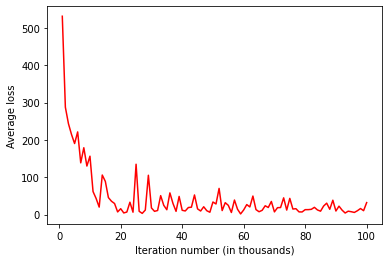

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_loss_2a = []
for i in range(0, len(i_list_2a), 10):
    avg_2a = sum(loss_list_2a[i:i+10]) / 10
    avg_loss_2a.append(avg_2a)

# Plot the average loss on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(avg_loss_2a)+1)), avg_loss_2a, color='red', linestyle='-')
# plt.plot(i_list, avg_loss, color='red', linestyle='--')

plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Average loss')
plt.show()


## Question 2b: two layers. Layer 1 with 13 output neurons with sigmoid activation. Layer 2 with one output neuron and linear activation. use mean squared loss

In [ ]:
i_list_2b = []
loss_list_2b = []

num_iterations = 1000000
def q2b(X_train, Y_train, learning_rate):
  # Layer 1 with 13 output neurons with sigmoid activation. Layer 2 with one output neuron and linear activation. use mean squared loss

  layer_list = [Dense((13,1), 13, learning_rate, Sigmoid()), Dense((13,1), 1, learning_rate)]

  mse = MeanSquaredLossLayer()
  nn = Neural_Network(layer_list, mse)
  for i in range(num_iterations) :
    size = len(X_train)
    # Selecting a random training sample
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1].T
    _y = Y_train[index:index+1].reshape(1,1)
    loss = nn.forward(_x, _y)
    if(i%1000==0) :
      i_list_2b.append(i)
      loss_list_2b.append(loss)
      print(f"Iteration: {i}, loss: {loss}")
    # Backward propogation to update the weights and biases
    nn.backward()
   # Returning the list of dense layers
  return nn.layer_list

learning_rate = 0.00001
# Getting the final list of dense layers after training
final_layer_list = q2b(X_train, y_train, learning_rate)
# Calculating the final loss after testing the trained network
final_loss = testing(X_test, y_test, final_layer_list)
# Printing the final mean squared loss
print("Mean Error in percentage: {:.9f}%".format(final_loss * 100))

Iteration: 0, loss: 1055.974524809792
Iteration: 1000, loss: 216.45333992479976
Iteration: 2000, loss: 327.5388190181447
Iteration: 3000, loss: 644.8602643206785
Iteration: 4000, loss: 591.1351414950495
Iteration: 5000, loss: 205.05853614698722
Iteration: 6000, loss: 480.58229931855516
Iteration: 7000, loss: 400.5845852471364
Iteration: 8000, loss: 518.616795420336
Iteration: 9000, loss: 1795.6802152346354
Iteration: 10000, loss: 25.25489335063644
Iteration: 11000, loss: 274.65000450494915
Iteration: 12000, loss: 112.6618633554106
Iteration: 13000, loss: 3.921238496599141
Iteration: 14000, loss: 20.85232334441548
Iteration: 15000, loss: 21.102494013097626
Iteration: 16000, loss: 151.225748440947
Iteration: 17000, loss: 14.074447744530595
Iteration: 18000, loss: 131.62491926658956
Iteration: 19000, loss: 310.2245430634127
Iteration: 20000, loss: 103.64086172726262
Iteration: 21000, loss: 92.18824274434779
Iteration: 22000, loss: 36.74539093716098
Iteration: 23000, loss: 52.6106352190977

## Plot of the Average Loss V/S Number of Iterations for 2.b



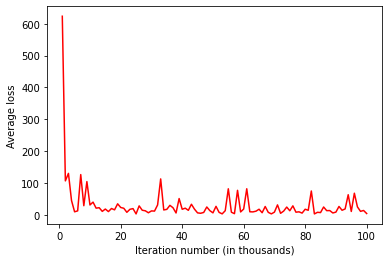

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_loss_2b = []
for i in range(0, len(i_list_2b), 10):
    avg_2b = sum(loss_list_2b[i:i+10]) / 10
    avg_loss_2b.append(avg_2b)

# Plot the average loss on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(avg_loss_2b)+1)), avg_loss_2b, color='red', linestyle='-')
# plt.plot(i_list, avg_loss, color='red', linestyle='--')

plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Average loss')
plt.show()


## Question 2c: three layers. Layer 1 with 13 output neurons with sigmoid activation. Layer 2 with 13 output neurons and sigmoid activation. Layer 3 with one output neuron and linear activation. use mean squared loss

In [ ]:
i_list_2c = []
loss_list_2c = []

num_iterations = 1000000
def q2c(X_train, Y_train, learning_rate):

  # three layers: Layer 1 with 13 output neurons with sigmoid activation.
  # Layer 2 with 13 output neurons and sigmoid activation. 
  # Layer 3 with one output neuron and linear activation. use mean squared loss

  layer_list = [Dense((13,1), 13,learning_rate, Sigmoid()), Dense((13,1), 13, learning_rate, Sigmoid()), Dense((13,1), 1, learning_rate)]
  mse = MeanSquaredLossLayer()
  nn = Neural_Network(layer_list, mse)

  # Train the model for specified number of iterations
  for i in range(num_iterations) :
    size = len(X_train)
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1].T
    _y = Y_train[index:index+1].reshape(1,1)
    loss = nn.forward(_x, _y)
    if(i%1000==0) :
      i_list_2c.append(i)
      loss_list_2c.append(loss)
      print(f"Iteration: {i}, loss: {loss}")
    nn.backward()
  
  return nn.layer_list

learning_rate = 0.00001
final_layer_list = q2c(X_train, y_train, learning_rate)
final_loss = testing(X_test, y_test, final_layer_list)
# Printing the final mean squared loss
print("Mean Error in percentage: {:.9f}%".format(final_loss * 100))

Iteration: 0, loss: 394.2989439670646
Iteration: 1000, loss: 205.2749091615667
Iteration: 2000, loss: 398.8157331367635
Iteration: 3000, loss: 381.2948623180626
Iteration: 4000, loss: 198.23853225321017
Iteration: 5000, loss: 194.38407255044976
Iteration: 6000, loss: 136.6633497169492
Iteration: 7000, loss: 210.82658636583685
Iteration: 8000, loss: 99.11657011597646
Iteration: 9000, loss: 50.3343569979929
Iteration: 10000, loss: 133.27179511704423
Iteration: 11000, loss: 110.51872785685843
Iteration: 12000, loss: 44.96808896047402
Iteration: 13000, loss: 1022.588290100034
Iteration: 14000, loss: 15.359475249688453
Iteration: 15000, loss: 28.14426260327689
Iteration: 16000, loss: 140.96309401927445
Iteration: 17000, loss: 36.58928755977067
Iteration: 18000, loss: 19.51996707640828
Iteration: 19000, loss: 28.94473294825413
Iteration: 20000, loss: 7.426037912802712
Iteration: 21000, loss: 0.6597248334756796
Iteration: 22000, loss: 20.064634968948333
Iteration: 23000, loss: 69.514747539047

## Plot of the Average Loss V/S Number of Iterations for 2.c

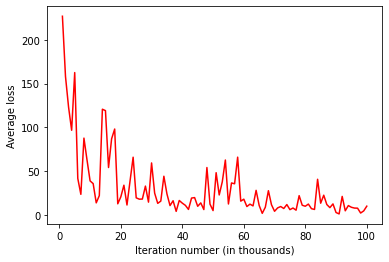

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_loss_2c = []
for i in range(0, len(i_list_2c), 10):
    avg_2c = sum(loss_list_2c[i:i+10]) / 10
    avg_loss_2c.append(avg_2c)

# Plot the average loss on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(avg_loss_2c)+1)), avg_loss_2c, color='red', linestyle='-')
# plt.plot(i_list, avg_loss, color='red', linestyle='--')

plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Average loss')
plt.show()


## Question 3

## Loading the mnist (sklearn) dataset

In [8]:
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Load the digits dataset into the variable "mnist"
mnist = load_digits()

# Store the features (pixel values) in the variable X_
X_ = (mnist.data)
# Store the target (digit labels) in the variable Y_
Y_ = (mnist.target)

X_train, X_test, Y_train_, Y_test_ = train_test_split(X_, Y_, test_size=0.10, random_state=42)

# Convert the training target labels into a one-hot encoded representation
Y_train = np.zeros((Y_train_.shape[0], 10))
Y_train[np.arange(Y_train_.shape[0]), Y_train_] = 1

# Convert the testing target labels into a one-hot encoded representation
Y_test = np.zeros((Y_test_.shape[0], 10))
Y_test[np.arange(Y_test_.shape[0]), Y_test_] = 1


### Testing function for calculating the accuracy of our model

In [ ]:
def testing_accuracy2(X_test, Y_test, layer_list):
  correct=0
  for i in range (len(X_test)):
    y_pred = X_test[i:i+1].T
    for layer_i in layer_list:
      y_pred = layer_i.forward(y_pred)

    # Get the index of the maximum prediction value
    mxi = y_pred.argmax(axis=0)

    # Check if the prediction matches the ground truth with a confidence of 0.9
    if(Y_test[i][mxi[0]]>0.9) :
      # If the prediction matches, increase the correct count
      correct += 1
  # Return the accuracy as the ratio of correct predictions to the total number of samples
  return correct / (len(Y_test))

##Question 3a: 
##Two layers. Layer 1 with 89 output neurons with tanh activation. Layer 2 with ten output neuron and sigmoid activation. use mean squared loss

In [ ]:
i_list = []
loss_list = []
num_iterations = 1000000

def q3a(X_train, Y_train, learning_rate):
  
  # two layers. Layer 1 with 89 output neurons with tanh activation. 
  # Layer 2 with ten output neuron and sigmoid activation. use mean squared loss.

  # Initialize the neural network with the layer list and the mean squared loss layer
  layer_list = [Dense((64,1), 89, learning_rate, Tanh()), Dense((89,1), 10, learning_rate, Sigmoid())]
  mse = MeanSquaredLossLayer()
  nn = Neural_Network(layer_list, mse)

  for i in range(1000000) :
    size = len(X_train)
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1].T
    _y = Y_train[index:index+1].reshape(10, 1)      
    loss = nn.forward(_x, _y)
    if(i%2000==0) :
      i_list.append(i)
      loss_list.append(loss)
      print(f"Iteration: {i}, loss: {loss}")
    
    # Perform the backward pass to update the weights
    nn.backward()
  # Return the final list of layers
  return nn.layer_list


learning_rate = 0.005
# Call the function to train the neural network
final_layer_list = q3a(X_train, Y_train, learning_rate)
# Calculate the accuracy of the trained model on the test data
accuracy_3a = testing_accuracy2(X_test, Y_test, final_layer_list)
# Print the accuracy
print("Accuracy of the Model: {:.9f}%".format(accuracy_3a * 100))

Iteration: 0, loss: 0.494376191301623
Iteration: 2000, loss: 0.25682223767488704
Iteration: 4000, loss: 0.055328459532889826
Iteration: 6000, loss: 0.10002319645684721
Iteration: 8000, loss: 0.10212132519113408
Iteration: 10000, loss: 0.16431788202501768
Iteration: 12000, loss: 0.10005830479079506
Iteration: 14000, loss: 0.10002702324874804
Iteration: 16000, loss: 0.1000000058316433
Iteration: 18000, loss: 0.0999870970833433
Iteration: 20000, loss: 0.02374690847112147
Iteration: 22000, loss: 0.09992954910724818
Iteration: 24000, loss: 0.0001259368527392687
Iteration: 26000, loss: 0.08866089620597556
Iteration: 28000, loss: 0.09999981255665272
Iteration: 30000, loss: 0.09992108620389716
Iteration: 32000, loss: 0.1000005267877219
Iteration: 34000, loss: 0.10212784750880351
Iteration: 36000, loss: 0.0021334986021039363
Iteration: 38000, loss: 0.003554503563827366
Iteration: 40000, loss: 0.08956862227177362
Iteration: 42000, loss: 0.0009238516297367683
Iteration: 44000, loss: 0.10002273117

### Plot of the Average Loss V/S Number of Iterations for 3.a

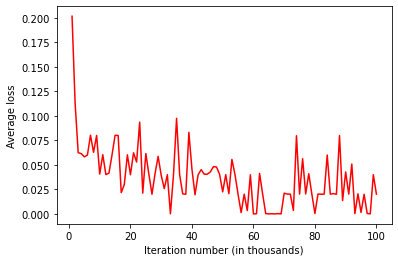

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_loss = []
for i in range(0, len(i_list), 5):
    avg = sum(loss_list[i:i+5]) / 5
    avg_loss.append(avg)

# Plot the average loss on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(avg_loss)+1)), avg_loss, color='red', linestyle='-')
# plt.plot(i_list, avg_loss, color='red', linestyle='--')

plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Average loss')
plt.show()


## Question 3b:

##two layers. Layer 1 with 89 output neurons with tanh activation. Layer 2 with ten output neuron and linear activation. use softmax with cross entropy loss.

In [ ]:
num_iterations = 1000000
i_list_3b = []
loss_list_3b = []

def q3b(X_train, Y_train, learning_rate):
  # two layers. Layer 1 with 89 output neurons with tanh activation. 
  # Layer 2 with ten output neuron and linear activation. use softmax with cross
  # entropy loss.


  layer_list = [Dense((64,1), 89, learning_rate*10, Tanh()), Dense((89,1), 10, learning_rate), SoftmaxLayer()]
  cel = CrossEntropyLayer()
  nn = Neural_Network(layer_list, cel)
  for i in range(num_iterations) :
    size = len(X_train)
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1].T
    _y = Y_train[index:index+1].reshape(10,1)
    loss = nn.forward(_x, _y)
    if(i%4000==0) :
      i_list_3b.append(i)
      loss_list_3b.append(loss)
      print(f"Iteration: {i}, loss: {loss}")
    # Perform the backward pass to update the weights
    nn.backward()
  return nn.layer_list


learning_rate = 0.0001
# Call the function to train the neural network
final_layer_list = q3b(X_train, Y_train, learning_rate)
# Calculate the accuracy of the trained model on the test data
accuracy_3b = testing_accuracy2(X_test, Y_test, final_layer_list)
# Print the accuracy
print("Accuracy of the Model: {:.9f}%".format(accuracy_3b * 100))

Iteration: 0, loss: 30.78849868826918
Iteration: 4000, loss: 0.19845802081241964
Iteration: 8000, loss: 0.0002481118988891641
Iteration: 12000, loss: 0.0035597307965355486
Iteration: 16000, loss: 7.449445899307113e-05
Iteration: 20000, loss: 0.0014522429776547495
Iteration: 24000, loss: 0.0064908614794951525
Iteration: 28000, loss: 0.4792890071890399
Iteration: 32000, loss: 0.21176853155981598
Iteration: 36000, loss: 0.023238046686166827
Iteration: 40000, loss: 0.024919592930813667
Iteration: 44000, loss: 0.0748681757240151
Iteration: 48000, loss: 0.23769765806288362
Iteration: 52000, loss: 0.001917783429206833
Iteration: 56000, loss: 0.03942215379141056
Iteration: 60000, loss: 0.025301774826134774
Iteration: 64000, loss: 0.0026511760731970572
Iteration: 68000, loss: 1.35879110101132
Iteration: 72000, loss: 4.169767505724567
Iteration: 76000, loss: 10.803750826768132
Iteration: 80000, loss: 0.21390524825562632
Iteration: 84000, loss: 2.7721024834869212e-05
Iteration: 88000, loss: 0.001

### Plot of the Average Loss V/S Number of Iterations for 3.b




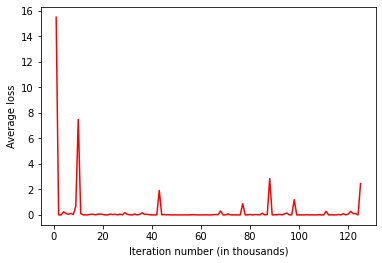

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_loss_3b = []
for i in range(0, len(i_list_3b), 2):
    avg_3b = sum(loss_list_3b[i:i+2]) / 2
    avg_loss_3b.append(avg_3b)

# Plot the average loss on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(avg_loss_3b)+1)), avg_loss_3b, color='red', linestyle='-')
# plt.plot(i_list, avg_loss, color='red', linestyle='--')

plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Average loss')
plt.show()


## Q.4 Implement the convolution layer for 1 channel input and (n >= 1) channel output. Implement both forward and backward passes. Implement the flatten operation

## Q.5 (extra credit bonus:) generalize this for any number of input and any number of output channel. Implement both forward and backward passes

*Here we have implemented the 5th Question (for the general case i.e for any number of input and any number of output channel), keeping the Question.4 as the default case in the class implemented in Question 5.*

## Cross-Correlate2d Function From Scratch

In [7]:
import numpy as np
from scipy import signal
# Function to calculate the 2D cross-correlation of an image with a kernel.

def correlate2d(image, kernel, mode='valid'):
    """
    Parameters:
    image (ndarray): Input image.
    kernel (ndarray): Input kernel.
    mode (str, optional): Mode for correlation calculation.
        'valid': only valid positions (no padding).
        'same': pads the input so the output has the same shape as the input.
        'full': padding such that the output size is max(M, N) - min(M, N) + 1.
    """
    image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape

    # Perform the operation depending upon the mode selected

    if mode == 'valid':
        result = np.zeros((image_rows - kernel_rows + 1, image_cols - kernel_cols + 1))
    elif mode == 'same':
        result = np.zeros(image.shape)
    elif mode == 'full':
        result = np.zeros((image_rows + kernel_rows - 1, image_cols + kernel_cols - 1))
    else:
        raise ValueError("mode can only be 'valid', 'same' or 'full'")

    # Padding for image
    if mode == 'same' or mode == 'full':
        padding_rows = kernel_rows // 2
        padding_cols = kernel_cols // 2
        image = np.pad(image, ((padding_rows, padding_rows), (padding_cols, padding_cols)), 'constant')

    # Matrix Multiplication
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i][j] = (image[i:i+kernel_rows, j:j+kernel_cols] * kernel).sum()

    return result


## Convolve2d Function From Scratch



In [6]:
import numpy as np
def convolve2d(image, kernel, mode='full'):
    # Flip the kernel along both the horizontal and vertical axes
    flipped_kernel = np.fliplr(np.flipud(kernel))
    
    # Call the convolve2d function with the flipped kernel
    result = correlate2d(image, flipped_kernel, mode)
    return result

## Padding Matrix With Zeros Function 

In [5]:
import numpy as np

# Function takes an input matrix and pads it with zeros.
# The input matrix is padded on all sides with a size of pad_size.
def pad_with_zeros(input_matrix, pad_size):
    return np.pad(input_matrix, [(pad_size, pad_size), (pad_size, pad_size)], 'constant')

## Flatten Class

In [4]:
class Flatten:
    def __init__(self):
        # Initialize an attribute to store the input shape
        self.input_shape = None

    def forward(self, x):
        # Store the input shape for the backward pass
        self.input_shape = x.shape
        # Flatten the input into a 1D array
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        # Transpose dout
        dout = dout.T
        # Reshape dout back to its original shape
        return dout.reshape(*self.input_shape)


In [18]:
import numpy as np

class CNN():

    # class constructor to initialize the CNN
    def __init__(self, input_height, input_width, kernel_size, output_channel, learning_rate, activation=None, input_channel = 1, seed_kernel=None, seed_bias=None):
        self.input_height = input_height
        self.input_width = input_width
        self.output_channel = output_channel
        self.input_channel = input_channel
        self.kernel_size = kernel_size
        self.output_shape = (output_channel, input_height - kernel_size+1, input_width - kernel_size+1)
        self.kernels_shape = (output_channel, input_channel, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)
        self.learning_rate = learning_rate
        
        # use provided seeds if they are not None
        if(seed_kernel is not None) :
          self.kernels = seed_kernel
        if(seed_bias is not None) :
          self.biases = seed_bias
        self.activation = activation

    # forward pass of the CNN
    def forward(self, input):
        self.input = input
        # create a copy of the biases to store the output
        self.output = np.copy(self.biases)
        for i in range(self.output_channel):
            for j in range(self.input_channel):
              # perform cross-correlation between each input channel and corresponding kernel
                # self.output[i] += correlate2d(self.input[j], self.kernels[i, j], "valid")
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")

        # flatten the output tensor
        self.output = self.output.reshape(-1,1) #flattening
        
        # perform activation if provided
        if(self.activation is not None) :
          self.output = self.activation.forward(self.output)
        
        # return the output
        return self.output

    # backward pass of the CNN
    def backward(self, output_gradient):
      # perform backward activation if provided
        if(self.activation is not None) :
          output_gradient = self.activation.backward(output_gradient)
        
        output_gradient = output_gradient.reshape(self.output_channel, self.input_height-self.kernel_size+1, self.input_width - self.kernel_size+1) #reversing flattening
        
        # initialize the gradient of the kernels and input 
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros((self.input_channel,  self.input_height,  self.input_width))

        # compute the gradient of the kernels and input
        for i in range(self.output_channel):
            for j in range(self.input_channel):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i][j], "full")

        self.kernels -= self.learning_rate * kernels_gradient
        self.biases -= self.learning_rate * output_gradient
        return input_gradient

## Testing Function for Calculating Accuracy of the Model

In [19]:
def testing_accuracy3(X_test, Y_test, layer_list):
  correct=0
  for i in range (len(X_test)):
    y_pred = X_test[i:i+1]
    for layer_i in layer_list:
      y_pred = layer_i.forward(y_pred)
    # Get the index of the maximum prediction value
    mxi = y_pred.argmax(axis=0)
    # Check if the prediction matches the ground truth with a confidence of 0.9
    if(Y_test[i][mxi[0]]>0.9) :
      # If the prediction matches, increase the correct count
      correct += 1

  # Return the accuracy as the ratio of correct predictions to the total number of samples
  return correct / (len(Y_test))

## Q.6 Train this CNN on mnist dataset. Layer 1: Convolution layer with 16 out-put channels+flatten+tanh activation. Layer 2: 10 output neuron with linear activation. Softmax cross entropy loss

In [20]:
X_train_6 = X_train.reshape(len(X_train), 8, 8)
X_test_6 = X_test.reshape(len(X_test), 8, 8)


In [22]:
num_iterations = 1000000
i_list_6 = []
loss_list_6 = []
accuracy_list_6 = []

def q6(X_train, Y_train, learning_rate):
  
  # Layer 1: Convolution layer with 16 out-put channels+flatten+tanh activation. 
  # Layer 2: 10 output neuron with linear activation. Softmax cross entropy loss
  layer_list = [CNN(8, 8, 2, 16, learning_rate, Tanh()), Dense((16*7*7,1), 10, learning_rate), SoftmaxLayer()]
  cel = CrossEntropyLayer()
  nn = Neural_Network(layer_list, cel)
  for i in range(num_iterations) :
    size = len(X_train)
    index = np.random.randint(low = 0,high = size)
    _x = X_train[index:index+1]
    _y = Y_train[index].reshape(10,1)
    loss = nn.forward(_x, _y)
    if(i%2000==0) :
      i_list_6.append(i)
      loss_list_6.append(loss)
      new_layer_list = nn.layer_list
      accuracy_list_6.append(100*testing_accuracy3(X_test_6[0:30], Y_test[0:30], new_layer_list))
      print(f"Iteration: {i}, loss: {loss}")
    nn.backward()
  return nn.layer_list

learning_rate = 0.0001
# Call the function to train the neural network
final_layer_list = q6(X_train_6, Y_train, learning_rate)
# Calculate the accuracy of the trained model on the test data
accuracy_6 = testing_accuracy3(X_test_6, Y_test, final_layer_list)
# Print the accuracy
print("Accuracy of the Model: {:.9f}%".format(accuracy_6 * 100))

Iteration: 0, loss: 45.998373262921916
Iteration: 2000, loss: 9.106855119438524
Iteration: 4000, loss: 10.875693701222671
Iteration: 6000, loss: 27.124800654750022
Iteration: 8000, loss: 26.402787805337734
Iteration: 10000, loss: 28.252534378142357
Iteration: 12000, loss: 3.126562782048754
Iteration: 14000, loss: 25.11042256118517
Iteration: 16000, loss: 24.852429981711527
Iteration: 18000, loss: 0.020449790328781702
Iteration: 20000, loss: -8.505598447393633e-10
Iteration: 22000, loss: 28.682620631726216
Iteration: 24000, loss: -9.701928149279935e-10
Iteration: 26000, loss: 30.67029899334876
Iteration: 28000, loss: 28.06202422401421
Iteration: 30000, loss: 27.561893197382542
Iteration: 32000, loss: 1.4352017247192283e-06
Iteration: 34000, loss: -9.758094332090874e-10
Iteration: 36000, loss: 1.8291097771427827
Iteration: 38000, loss: 9.025517801744437e-09
Iteration: 40000, loss: 3.9918446361611556e-10
Iteration: 42000, loss: 20.72732490700872
Iteration: 44000, loss: 0.00020779206216484

## Plot of the Average Loss V/S Number of Iterations for Q.6

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the accuracy on the y-axis and the iteration number on the x-axis
plt.plot(list(range(1, len(accuracy_list_6)+1)), accuracy_list_6, color='red', linestyle='-')
plt.xlabel('Iteration number (in thousands)')
plt.ylabel('Accuracy')
plt.show()






